In [1]:
import sys
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import metrics
from xgboost import plot_importance
from matplotlib import pyplot


In [2]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 3

In [3]:
from datetime import datetime
print('Start Time: ', str(datetime.now()))

Start Time:  2019-09-30 22:54:39.362779


In [4]:
import csv
import gc
def get_data(directory, file_list, chunksize, data_type_list = None, use_col_list = None):
    # type: (str, list, list, list) -> pd.DataFrame
    """
    :param directory: input directory location
    :param file_list: list of files to read
    :param data_type_list: list of data types for each file (ex. int, str, etc)
    :param use_col_list: list of columns to read from
    :return: dataframe of all files
    """

    data = None
    for i, file_name in enumerate(file_list):
        #print (file_name)
        subset = None
        for j, chunk in enumerate(
                pd.read_csv(directory + file_name, chunksize=chunksize, low_memory=False, index_col=0)):
            #print (j)
            if subset is None:
                subset = chunk.copy()
            else:
                subset = pd.concat([subset, chunk])
            del chunk
            gc.collect()
        if data is None:
            data = subset.copy()
        else:
            data = pd.merge(data, subset.copy(), on="Id")
        del subset
        gc.collect()

    return data


In [5]:
train = get_data('D:/Project/Sample data/', ['train_numeric_5.csv'], 10000)
#print(train.head())
columns = train.drop(["Response"], axis=1).columns
print(columns)
# frac = float(sys.argv[1])
# num = int(sys.argv[2])
# print('frac:', frac)
# print('num:', num)

Index(['L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8', 'L0_S0_F10',
       'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16', 'L0_S0_F18',
       ...
       'L3_S50_F4243', 'L3_S50_F4245', 'L3_S50_F4247', 'L3_S50_F4249',
       'L3_S50_F4251', 'L3_S50_F4253', 'L3_S51_F4256', 'L3_S51_F4258',
       'L3_S51_F4260', 'L3_S51_F4262'],
      dtype='object', length=968)


In [6]:
def getSample(frac):
    data =train.sample(frac=frac)
    return data

In [7]:


def modelfit(alg, X_all, y_all,i, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    import xgboost as xgb


    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_all, label=y_all)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=1)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_all, y_all, eval_metric=['auc'])
    
    print(alg)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_all)
    dtrain_predprob = alg.predict_proba(X_all)[:,1]
    
    sorted_idx = np.argsort(alg.feature_importances_)[::-1]
    f_name = []
    score = []
    print('Important Features:')
    for index in sorted_idx:
        f_name.append(columns[index])
        score.append(alg.feature_importances_[index])
    im_Feature= pd.DataFrame(f_name, columns =["f_name"])
    im_Feature["score"] = score
    im_Feature=im_Feature.head(49)
    out_file = "D:/input output csv_10" + "/data_{}.csv".format(i+1)

    im_Feature.to_csv(out_file)
    print(im_Feature.head())
    #Print model report:
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_all, dtrain_predprob))

    out_file = "D:/input output csv_10" + "/data_{}.png".format(i+1)

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:25]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig(out_file)
    print(feat_imp.to_string())
    del alg
    gc.collect()
    


         L0_S0_F0  L0_S0_F2  L0_S0_F4  L0_S0_F6  L0_S0_F8  L0_S0_F10  \
Id                                                                     
477790      0.003    -0.026     0.003     0.003     0.031     -0.021   
2242067       NaN       NaN       NaN       NaN       NaN        NaN   
497761        NaN       NaN       NaN       NaN       NaN        NaN   
1085097    -0.134    -0.101    -0.197    -0.161     0.031      0.206   
1529311       NaN       NaN       NaN       NaN       NaN        NaN   

         L0_S0_F12  L0_S0_F14  L0_S0_F16  L0_S0_F18  ...  L3_S50_F4245  \
Id                                                   ...                 
477790       0.000      0.008     -0.138      0.077  ...           NaN   
2242067        NaN        NaN        NaN        NaN  ...           NaN   
497761         NaN        NaN        NaN        NaN  ...           NaN   
1085097      0.022      0.048     -0.128     -0.174  ...           NaN   
1529311        NaN        NaN        NaN        NaN

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.699892+0.0265552	test-auc:0.552798+0.0260564
[1]	train-auc:0.771596+0.0175413	test-auc:0.575455+0.0102651
[2]	train-auc:0.792788+0.0202864	test-auc:0.599007+0.0230897
[3]	train-auc:0.826897+0.0124139	test-auc:0.60809+0.0618358
[4]	train-auc:0.83933+0.00846169	test-auc:0.61545+0.0475339
[5]	train-auc:0.848074+0.00509633	test-auc:0.611136+0.0420177
[6]	train-auc:0.862499+0.00731627	test-auc:0.610562+0.0427853
[7]	train-auc:0.878872+0.019104	test-auc:0.606725+0.0451897
[8]	train-auc:0.882457+0.0191861	test-auc:0.608988+0.035199
[9]	train-auc:0.888006+0.021471	test-auc:0.615132+0.0336699
[10]	train-auc:0.898099+0.0126015	test-auc:0.617931+0.0377871
[11]	train-auc:0.904479+0.0105324	test-auc:0.615384+0.036254
[12]	train-auc:0.911441+0.008671	test-auc:0.608208+0.0370026
[13]	train-auc:0.912294+0.00973194	test-auc:0.613436+0.04094
[14]	train-auc:0.916857+0.0110249	test-auc:0.617043+0.036956
[15]	train-auc:0.919709+0.0102567	test-auc:0.624843+0.0321103
[16]	train-auc:0.922289+0

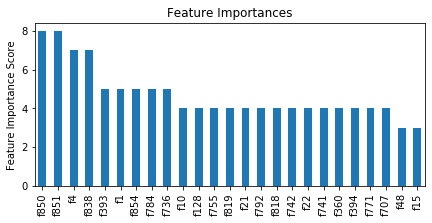

In [8]:
for num in np.arange(1):
    X_all = getSample(0.10)
    print(X_all.head())
    y_all = X_all['Response']
    X_all = X_all.iloc[:,:-1].values
    print(X_all)
    from xgboost.sklearn import XGBClassifier
    xgb1 = XGBClassifier(learning_rate=0.05,
                     base_score=0.0056,
                     n_estimators=50,
                     min_child_weight=1,
                     gamma=0.1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=3)
    modelfit(xgb1, X_all, y_all, num)